In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

- 전처리 된 데이터 프레임 불러오기

In [5]:
PROCESSED_DIR = os.path.join('..', '전처리완료')

df_customers = pd.read_parquet(os.path.join(PROCESSED_DIR, 'customers_clean.parquet'))
df_articles = pd.read_parquet(os.path.join(PROCESSED_DIR, 'articles_clean.parquet'))
df_transactions = pd.read_parquet(os.path.join(PROCESSED_DIR, 'transactions_clean.parquet'))

print("---" * 15)
print(" 전처리 된 데이터 불러오기 성공")

---------------------------------------------
 전처리 된 데이터 불러오기 성공


- 폰트 깨짐 방지

In [6]:
import platform
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic') 
else:
    # 리눅스 전용 코드
    plt.rc('font', family='NanumGothic')

# 마이너스 기호가 깨지는 것을 방지
plt.rcParams['axes.unicode_minus'] = False

- 테이블 조인 (필요한 컬럼만 가져와야 메모리 효율이 높음)

In [ ]:

df_merged = pd.merge(df_transactions[['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id']], 
                     df_customers[['customer_id', 'age_group_biz']], 
                     on='customer_id', how='inner')

df_merged = pd.merge(df_merged, 
                     df_articles[['article_id', 'prod_name', 'product_group_name', 'graphical_appearance_name', 'index_group_name']], 
                     on='article_id', how='left')

# 2. 장바구니(Basket) 정의: 같은 날짜 + 같은 고객

# basket_size ----> 장바구니에 담긴 상품 개수
basket_df = df_merged.groupby(['t_dat', 'customer_id']).agg({
    'article_id': 'count',
    'age_group_biz': 'first' 
}).reset_index()

basket_df.rename(columns={'article_id': 'basket_size'}, inplace=True)

# 3. 단품(Single) vs 다품(Multi) 라벨링까지
basket_df['type'] = basket_df['basket_size'].apply(lambda x: 'Single (1개)' if x == 1 else 'Multi (2개 이상)')

print("---분석 준비 확인---")

✅ 분석 준비 완료!


- WHO 누가 1개만 사는가?

<Figure size 1200x600 with 0 Axes>

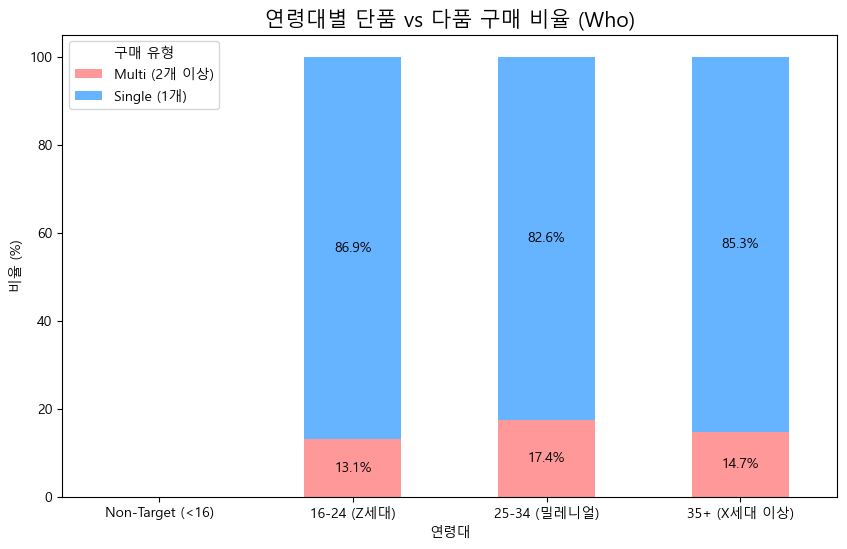

In [8]:
# 1. 연령대별 단품/다품 비율 계산
age_basket_counts = basket_df.groupby(['age_group_biz', 'type'], observed=False).size().unstack(fill_value=0)

# 2. 비율(%)로 변환 (각 연령대별 합이 100%가 되도록)
age_basket_ratio = age_basket_counts.div(age_basket_counts.sum(axis=1), axis=0) * 100

# 3. 시각화 --> Bar 차트
plt.figure(figsize=(12, 6))
ax = age_basket_ratio.plot(kind='bar', stacked=True, color=['#ff9999', '#66b3ff'], figsize=(10, 6))

plt.title("연령대별 단품 vs 다품 구매 비율 (Who)", fontsize=15)
plt.ylabel("비율 (%)")
plt.xlabel("연령대")
plt.legend(title='구매 유형', loc='upper left')
plt.xticks(rotation=0)

# 비율 숫자 표시
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0: 
        ax.text(x+width/2, y+height/2, f'{height:.1f}%', ha='center', va='center')

plt.show()

그래서 나온 결과는?

- 그래프를 보면, 25-34세 그룹이 17.4%로 다품 구매 비율이 가장 높고, 16-24세 그룹이 86.9%로 단품 구매 비율이 가장 높다.

- 뭔가 크게 의미있는 인사이트는 아니고 거진 대부분이 단품 구매 고객임


- What 어떤 상품이 '혼자' 팔리는가?

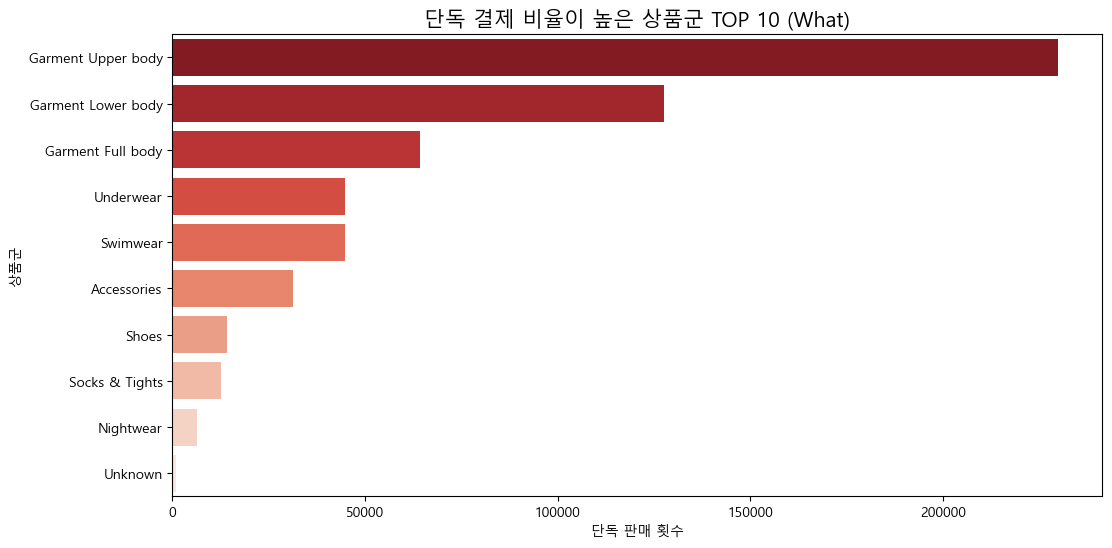

In [9]:
# 1. '단품 구매' 거래만 필터링
single_baskets = basket_df[basket_df['type'] == 'Single (1개)']
single_transactions = df_merged[df_merged.set_index(['t_dat', 'customer_id']).index.isin(single_baskets.set_index(['t_dat', 'customer_id']).index)]

# 2. 상품 그룹별 단독 판매 횟수 집계 --> 상위 10개만
top_lonely_items = single_transactions['product_group_name'].value_counts().head(10)

# 3. 시각화
df_lonely_plot = top_lonely_items.reset_index()

# 컬럼 이름을 명확히 지정해줍니다.
df_lonely_plot.columns = ['상품군', '단독 판매 횟수']
plt.figure(figsize=(12, 6))
sns.barplot(x='단독 판매 횟수', y='상품군', 
            data=df_lonely_plot,      
            hue='상품군',             
            palette='Reds_r', 
            legend=False)

plt.title("단독 결제 비율이 높은 상품군 TOP 10 (What)", fontsize=15)
plt.xlabel("단독 판매 횟수")
plt.ylabel("상품군")
plt.show()